In [252]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [253]:
data = pd.read_csv("Iris.csv")


# Calculating Entropy
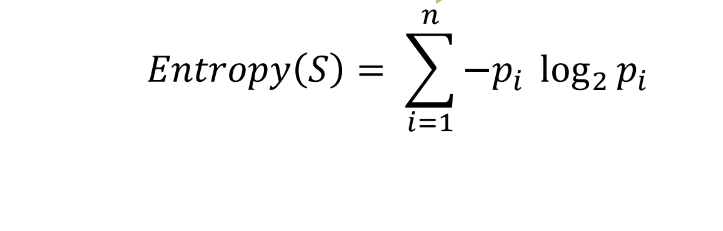



data[data['Species'] == label]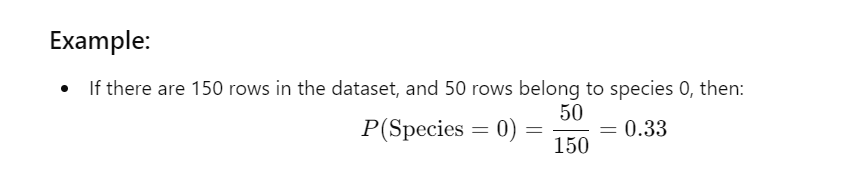
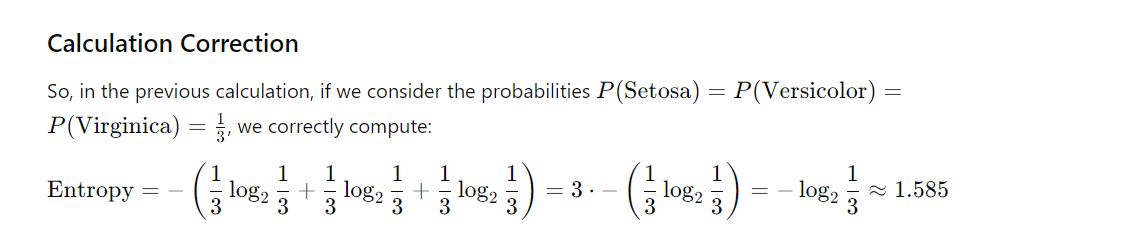

In [255]:
def entropy(data):
    labels = data['Species'].unique() # return list of species in numerical value ----->[0,1,2] 0=setosa  1=versicolor  2=virginica 
    entropy_value = 0
    for label in labels:
        probability = len(data[data['Species'] == label]) / len(data)   
        entropy_value -= probability * np.log2(probability)
    return entropy_value

# 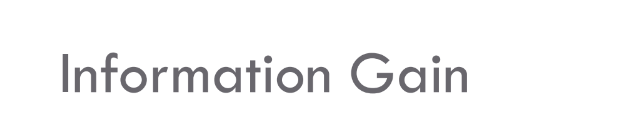
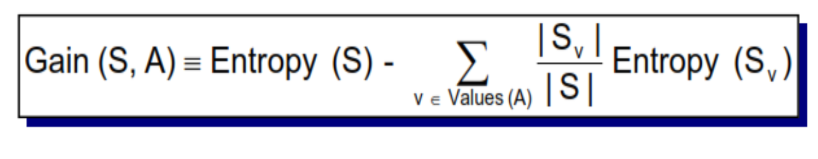

In [257]:
def information_gain(data, feature):
    total_entropy = entropy(data)      # -------> similarly it is calculating entropy for entire dta set of all features
    values = data[feature].unique()
    print(values)
    feature_entropy = 0
    for value in values:
        subset = data[data[feature] == value]
        probability = len(subset) / len(data)
        feature_entropy += probability * entropy(subset)
    return total_entropy - feature_entropy

# Defining all nodes of data set

In [259]:

class Node:
    def __init__(self, feature=None, value=None, label=None, branches=None):
        self.feature = feature
        self.value = value
        self.label = label
        self.branches = branches if branches is not None else []


# ID3 Algorithm Implementation for Decision Tree Construction
# depth: The current depth of the tree (default is 0).
# 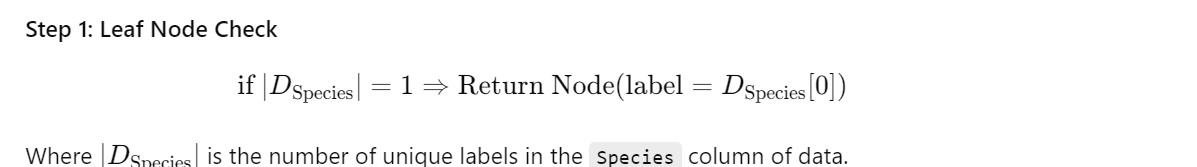
# 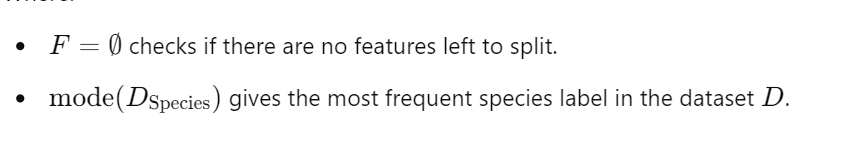

# This selects the feature that provides the highest information gain for splliting data


In [261]:
def id3(data, features, depth=0, max_depth=5):
    if len(data['Species'].unique()) == 1: 
        return Node(label=data['Species'].unique()[0])
    
    if not features or depth == max_depth:
        return Node(label=data['Species'].mode()[0])

    gains = {feature: information_gain(data, feature) for feature in features}
    best_feature = max(gains, key=gains.get)
    tree = Node(feature=best_feature)
    
    unique_values = np.unique(data[best_feature])
    for value in unique_values:
        subset = data[data[best_feature] == value]
        subtree = id3(subset, [f for f in features if f != best_feature], depth + 1)
        tree.branches.append((value, subtree))

    return tree


# Gini Impurity Calculation Function
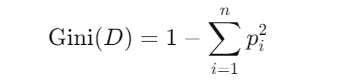

In [263]:
def gini(data):
    labels = data['Species'].unique()
    gini_value = 1
    for label in labels:
        probability = len(data[data['Species'] == label]) / len(data)
        gini_value -= probability ** 2
    return gini_value


# Gini Gain Calculation Function

In [265]:
def gini_gain(data, feature):
    values = data[feature].unique()
    gini_value = gini(data)
    feature_gini = 0
    for value in values:
        subset = data[data[feature] == value]
        probability = len(subset) / len(data)
        feature_gini += probability * gini(subset)
    return gini_value - feature_gini


# CART (Classification and Regression Trees) Function
# the CART Function will chosse best feature that provide best gini gain like in below picture it choose umidity as its gini gain was best
# 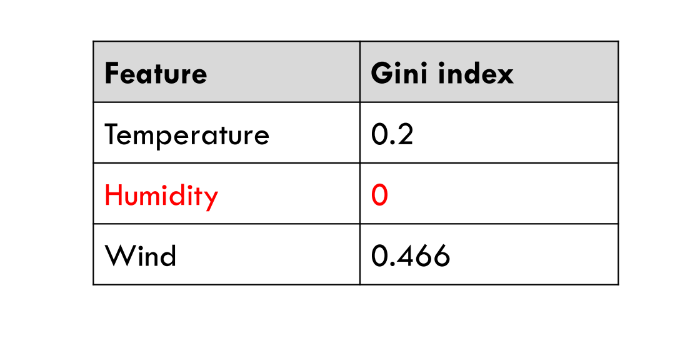
#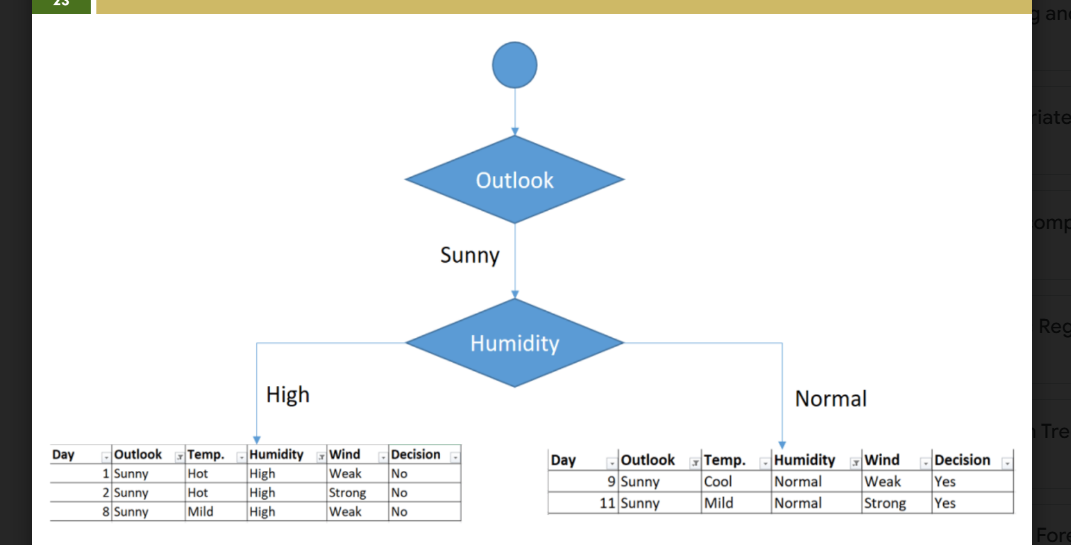
# The picture is just for example 

In [267]:
def cart(data, features, depth=0, max_depth=5):
    if len(data['Species'].unique()) == 1:  
        return Node(label=data['Species'].unique()[0])
    if not features or depth == max_depth:  
        return Node(label=data['Species'].mode()[0])

    gains = {feature: gini_gain(data, feature) for feature in features}
    best_feature = max(gains, key=gains.get)
    tree = Node(feature=best_feature)
    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        subtree = cart(subset, [f for f in features if f != best_feature], depth + 1)
        tree.branches.append((value, subtree))

    return tree


# Function to print the decision tree


In [269]:
def print_tree(node, spacing=""):
    if node.label is not None:
        print(spacing + "Predict:", node.label)
        return
    print(spacing + "Feature:", node.feature)
    for value, branch in node.branches:
        print(spacing + '--> ' + str(value))
        print_tree(branch, spacing + "  ")


# Function to Predict Class Labels from Decision Tree

In [271]:

def predict(tree, sample):
    if tree.label is not None:
        return tree.label  
    for value, branch in tree.branches:
        if tree.feature in sample and sample[tree.feature] == value:
            return predict(branch, sample)
    return None  


# Function to Calculate Accuracy of the Decision Tree

In [273]:

def accuracy(tree, test_data):
    correct = 0
    for _, row in test_data.iterrows():
        predicted_label = predict(tree, row)
        actual_label = row['Species']
        if predicted_label == actual_label:
            correct += 1
    return correct / len(test_data)


# Function to plot decision boundaries

In [275]:
def plot_decision_boundaries(tree, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = np.array([predict(tree, {features[0]: x1, features[1]: x2}) for x1, x2 in zip(np.ravel(xx), np.ravel(yy))])
    Z = np.array([z if z is not None else -1 for z in Z]) 
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')  
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title("Decision Boundary")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()


# This code is essential for preparing the Iris dataset for a decision tree classification task. It defines which features to use, converts categorical species labels to numeric values, and splits the dataset into training and testing subsets to facilitate model evaluation.
# Data Preparation for Decision Tree Classification

In [277]:
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
species_mapping = {species: idx for idx, species in enumerate(data['Species'].unique())}
data['Species'] = data['Species'].map(species_mapping)
train_data = data.sample(frac=0.8, random_state=1)  
test_data = data.drop(train_data.index) 


# Building and Evaluating an ID3 Decision Tree

In [279]:
id3_tree = id3(train_data, features)
id3_accuracy = accuracy(id3_tree, test_data)

[5.8 5.1 6.6 5.4 7.9 6.3 6.9 4.7 5.6 7.1 6.4 6.  4.4 5.  5.5 6.7 7.2 5.7
 6.1 7.7 5.3 5.2 6.5 6.8 4.8 7.3 6.2 4.6 4.9 5.9 7.4 7.6 4.5]
[4.  2.5 3.  3.9 3.8 3.3 3.1 3.2 2.7 2.9 2.6 3.4 3.5 2.8 4.2 3.7 2.3 2.2
 3.6 4.1 4.4 2.4]
[1.2 3.  4.4 1.3 6.4 4.7 5.1 1.9 1.6 5.7 4.2 1.7 5.9 4.5 4.  1.5 5.  6.
 4.1 1.4 4.6 6.1 3.9 5.6 5.8 5.5 6.9 6.7 5.4 6.3 4.8 4.9 4.3 3.3 5.3 6.6
 5.2 3.6 3.8]
[0.2 1.1 1.4 0.4 2.  1.6 2.3 1.3 2.1 1.5 1.2 1.7 0.3 1.8 1.9 2.4 2.2 0.1
 2.5 1.  0.5 0.6]
[6.4 6.  5.6 5.4 6.5 6.9]
[3.2 2.9 3.  2.8 2.2 3.1]
[4.5 4.6 5.  4.9]
[6.7 4.9]
[3.  2.5]
[5.  4.5]
[7.2 6.7 6.3 7.3 6.2 6.1 6.  6.5 5.9]
[3.2 2.5 2.9 2.8 2.7 3. ]
[6.  5.8 5.6 6.3 4.8 4.9 5.5 5.1]
[3.  3.2]
[5.1 4.8]


# building the CART decision tree using the training dataset
#  evaluating its performance on unseen test data. The resulting accuracy provides insight into how well the model is likely to generalize to new data.

In [281]:
cart_tree = cart(train_data, features)
cart_accuracy = accuracy(cart_tree, test_data)


# Printing Decsion Tree

In [283]:
print("Results of Decision Tree Classifiers:\n")
print("-" * 50)
print(f"Classifier: ID3 Algorithm")
print(f"Accuracy: {id3_accuracy * 100:.2f}%")
print("\nID3 Decision Tree Structure:")
print_tree(id3_tree)
print("\n" + "-" * 50)
print(f"\nClassifier: CART Algorithm")
print(f"Accuracy: {cart_accuracy * 100:.2f}%")
print("\nCART Decision Tree Structure:")
print_tree(cart_tree)

print("\n" + "-" * 50)


Results of Decision Tree Classifiers:

--------------------------------------------------
Classifier: ID3 Algorithm
Accuracy: 80.00%

ID3 Decision Tree Structure:
Feature: PetalWidthCm
--> 0.1
  Predict: 0
--> 0.2
  Predict: 0
--> 0.3
  Predict: 0
--> 0.4
  Predict: 0
--> 0.5
  Predict: 0
--> 0.6
  Predict: 0
--> 1.0
  Predict: 1
--> 1.1
  Predict: 1
--> 1.2
  Predict: 1
--> 1.3
  Predict: 1
--> 1.4
  Predict: 1
--> 1.5
  Feature: SepalWidthCm
  --> 2.2
    Predict: 2
  --> 2.8
    Predict: 1
  --> 2.9
    Predict: 1
  --> 3.0
    Predict: 1
  --> 3.1
    Predict: 1
  --> 3.2
    Predict: 1
--> 1.6
  Predict: 1
--> 1.7
  Feature: SepalLengthCm
  --> 4.9
    Predict: 2
  --> 6.7
    Predict: 1
--> 1.8
  Feature: SepalLengthCm
  --> 5.9
    Feature: SepalWidthCm
    --> 3.0
      Predict: 2
    --> 3.2
      Predict: 1
  --> 6.0
    Predict: 2
  --> 6.1
    Predict: 2
  --> 6.2
    Predict: 2
  --> 6.3
    Predict: 2
  --> 6.5
    Predict: 2
  --> 6.7
    Predict: 2
  --> 7.2
    Predict

# Visualizing Decision Boundaries for ID3 and CART Decision Trees

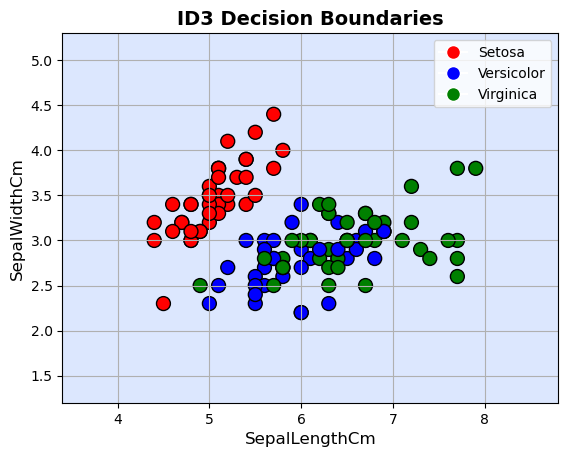

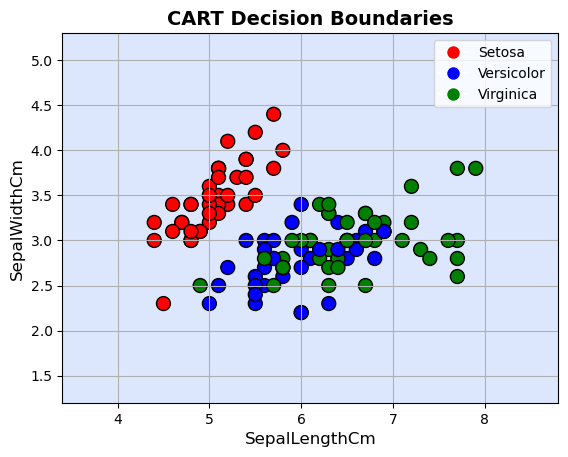

In [290]:
import matplotlib.pyplot as plt
import numpy as np
def plot_decision_boundaries(tree, X, y, title="Decision Boundary", color_map='coolwarm'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = np.array([predict(tree, {features[0]: x1, features[1]: x2}) for x1, x2 in zip(np.ravel(xx), np.ravel(yy))])
    Z = np.array([z if z is not None else -1 for z in Z])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=color_map)
    colors = {0: 'red', 1: 'blue', 2: 'green'}
    plt.scatter(X[:, 0], X[:, 1], c=[colors[label] for label in y], edgecolors='black', s=100, marker='o')
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Setosa', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Versicolor', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Virginica', markerfacecolor='green', markersize=10),
    ])
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(features[0], fontsize=12)
    plt.ylabel(features[1], fontsize=12)
    plt.grid(True)
    plt.show()
X = train_data[features[:2]].values
y = train_data['Species']
plot_decision_boundaries(id3_tree, X, y, title="ID3 Decision Boundaries")
plot_decision_boundaries(cart_tree, X, y, title="CART Decision Boundaries")
